In [115]:
from pymongo import MongoClient
client = MongoClient()
db = client.whosampled
import numpy as np
import pandas as pd
import re
import implicit
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import random
import scipy.sparse as sparse

import sys
np.set_printoptions(threshold=sys.maxsize)

from src.turn_db_main_into_utility_matrix import from_mongo_collection_to_utility_matrix

In [116]:
#Get utility matrices and cleaned up df.

utility_to_song, utility_to_artist, df = from_mongo_collection_to_utility_matrix(db.main_redo)

Without outliers removed, the mean and median time of sample appearance is 0:57 and 0:11, respectively.
With outliers removed, the mean and median are 0:49 and 0:11.


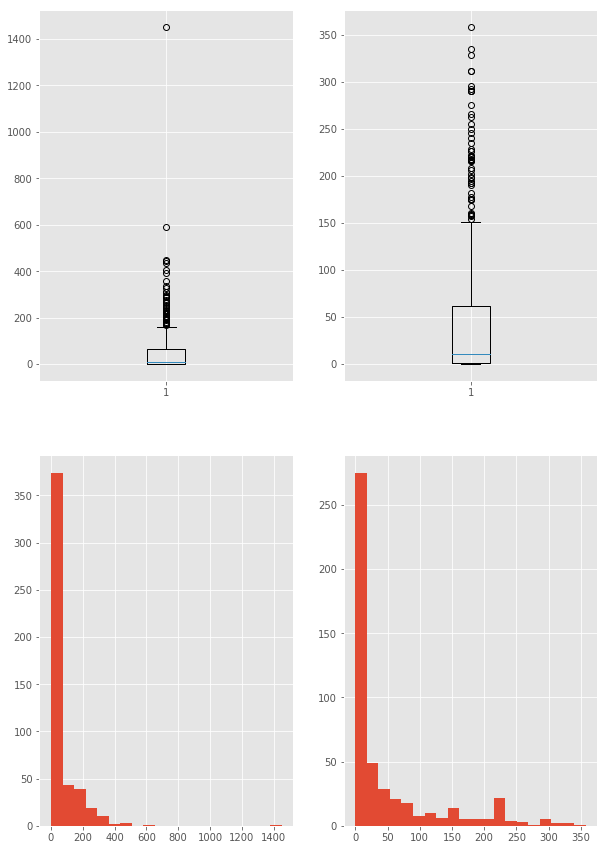

In [268]:
#Plot distribution of song_sample_times

subset = df.sample(n = 500)

# #Filter out "None Listed" in the time column
subset = subset[subset.time_in_sampled_song_where_sample_appears != "None Listed"]

# #Make new column with the number of seconds into a song the sample appears.
subset['seconds_into_song'] = \
        subset.time_in_sampled_song_where_sample_appears.apply(
        lambda x: x.split(":")).apply(
        lambda x: int(x[0]) * 60 +int(x[1]))

def get_mean_or_median_from_column(column, stat):
    '''
    Get mean in seconds and time format
    Put mean_minutes and seconds together to make time
    ''' 
    #Get mean or median of the column
    agg = int(stat(column))
    
    minutes = str(int(agg / 60))
    seconds = agg % 60    
    if seconds > 9:
        time = minutes + ":" + str(seconds)
    else: 
        time = minutes + ":0" + str(seconds)
    return time

def filter_df_outside_three_sds(column):
    
    '''
    Takes a column and calculates mean and std, then removes anything above that outer outlier bound.
    '''
    standard_deviation = column.std()
    outer_outlier_bound = np.mean(column) + 3 * standard_deviation
    filtered_subset = subset[subset.seconds_into_song < outer_outlier_bound]
    return filtered_subset

mean_time = get_mean_or_median_from_column(subset.seconds_into_song, np.mean)
median_time = get_mean_or_median_from_column(subset.seconds_into_song, np.median)

filtered_subset = filter_df_outside_three_sds(subset.seconds_into_song)

filtered_mean_time = get_mean_or_median_from_column(filtered_subset.seconds_into_song, np.mean)
filtered_median_time = get_mean_or_median_from_column(filtered_subset.seconds_into_song, np.median)

print(
"Without outliers removed, the mean and median time of sample appearance is {} and {}, respectively.\n\
With outliers removed, the mean and median are {} and {}."
    .format(mean_time, median_time, filtered_mean_time, filtered_median_time))

fig, ax = plt.subplots(figsize = (10, 15), nrows = 2, ncols =2)
ax[0, 0].boxplot(subset.seconds_into_song)
ax[0,1].boxplot(filtered_subset.seconds_into_song)
ax[1,0].hist(subset.seconds_into_song, bins= 20)
_ = ax[1,1].hist(filtered_subset.seconds_into_song, bins = 20)

In [273]:
subset.head()

,URL,_id,contributor_points,elements_sampled,name_of_contributor,new_song_album,new_song_artist,new_song_name,new_song_producer,new_song_year,"presence_of_""and throughout""_in_description",sampled_artist,sampled_song_album,sampled_song_name,sampled_song_producer,sampled_song_year,time_in_sampled_song_where_sample_appears,sampled_artist_song,seconds_into_song,Type of Sample
15147,https://www.whosampled.com/sample/599463/Ultra...,5ca4c54590a02a0280a67208,"Contributed by\nThe Actionist (41,667 )",Direct Sample,The Actionist,Funk Your Head Up,Ultramagnetic MC's,Funk Radio,Kool Keith,1992,Sample appears at 0:00 (and throughout),Art of Noise,In No Sense-Nonsense!,debut,,1987,1:44,Art of Noise - debut,104,Direct Sample
865,https://www.whosampled.com/sample/430935/9th-W...,5ca4461f90a02a02b7335e81,"Contributed by\nJordan Poon (2,678 )",Direct Sample of Vocals / Lyrics,Jordan Poon,Zion,9th Wonder,Ways I Love,9th Wonder,2016,Sample appears at 0:00 (and throughout),Toni Braxton,Toni Braxton,how many ways,Vincent Herbert,1993,0:00,Toni Braxton - how many ways,0,Direct Sample
10648,https://www.whosampled.com/sample/52764/Slick-...,5ca460d190a02a02ec8987a3,"Contributed by\nCellarDoor (39,142 )",Direct Sample of Multiple Elements,CellarDoor,The Art of Storytelling,Slick Rick,Kill Niggaz,Clark Kent,1999,Sample appears at 0:00 (and throughout),The O'Jays,So Full of Love,cry together,Gamble &amp; Huff,1978,0:5,The O'Jays - cry together,5,Direct Sample
49481,https://www.whosampled.com/sample/92764/Run-DM...,5ca8df35944f210638c66882,Contributed by\nMario Toledo Samples Chile (17...,Direct Sample of Vocals / Lyrics,Mario Toledo Samples Chile,Down With the King,Run-DMC,Come on Everybody,Jam Master Jay,1993,Sample appears at 0:14 (and throughout),Billy Squier,The Tale of the Tape,the big beat,"Billy Squier, Eddy Offord",1980,0:37,Billy Squier - the big beat,37,Direct Sample
23526,https://www.whosampled.com/sample/72929/Black-...,5ca6cd9e944f21209354ba0e,"Contributed by\njohnvw90 (1,973 )",Direct Sample of Vocals / Lyrics,johnvw90,Monkey Business,Black Eyed Peas,Like That,will.i.am,2005,Sample appears at 1:16,A Tribe Called Quest,People's Instinctive Travels and the Paths of ...,can i kick it?,A Tribe Called Quest,1990,0:33,A Tribe Called Quest - can i kick it?,33,Direct Sample


In [285]:
#Are they direct sample or interpolations?
subset = df.sample(n = 5000)

subset['type_of_sample'] = subset.elements_sampled.apply(lambda x: x.split("of")[0].strip() if "of" in x else x)
subset.elements_sampled = subset.elements_sampled.apply(lambda x: x.split("of")[1].strip() if "of" in x else "None Listed")

print(subset.elements_sampled.unique())
print(subset.type_of_sample.unique())

['Vocals / Lyrics' 'None Listed' 'Multiple Elements' 'Drums' 'Hook / Riff'
 'Bass' 'Dialogue' 'Score' 'Sound Effect / Other']
['Direct Sample' 'Interpolation (Replayed Sample)' 'Cover Version' 'Remix']


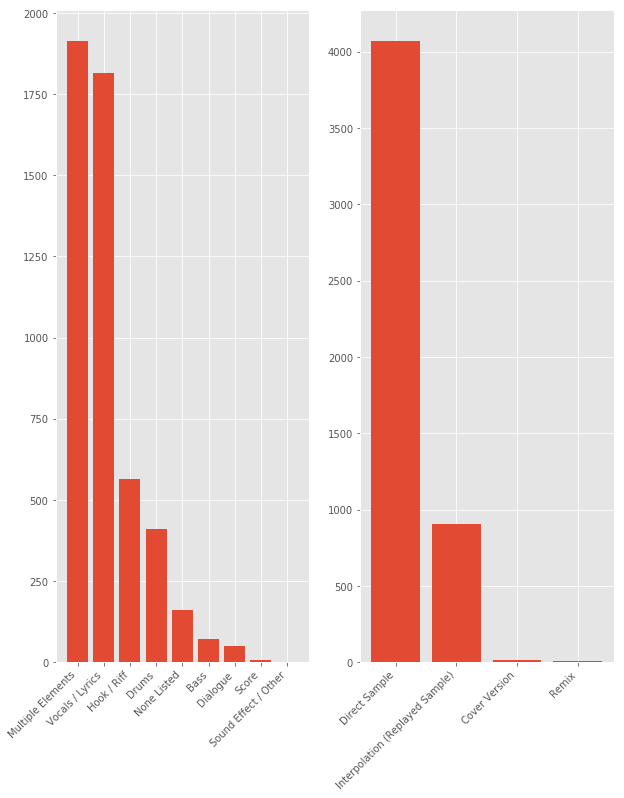

In [317]:
elements_counts = subset.groupby(subset.elements_sampled).agg(len)['URL'].sort_values(ascending = False)
type_counts = subset.groupby(subset.type_of_sample).agg(len)['URL'].sort_values(ascending = False)

fig, ax  = plt.subplots(nrows = 1, ncols =2, figsize = (10,12))

for position, graph in zip([0,1], [elements_counts, type_counts]):
    
    ax[position].set_xticklabels(graph.index, rotation = 45, ha = 'right')
    ax[position].bar(x = graph.index, height = graph.values)

In [123]:
song_sampled_pages_to_do = np.where(np.in1d(song_sample_pages, df.URL.unique()) == False)[0]
#song_sampled_pages_to_do2 = [song_sample_pages[i] for i in song_sampled_pages_to_do]

In [128]:
len(song_sampled_pages_to_do)

59919

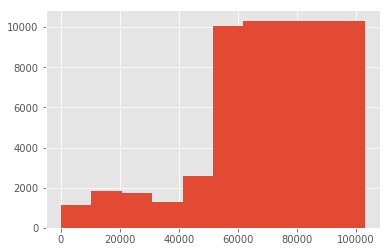

In [125]:
fig, ax = plt.subplots()
_=ax.hist(song_sampled_pages_to_do)

In [120]:
len(df.URL.unique())

43306

In [122]:
song_sample_pages = db.song_sample_pages.distinct('link')
print(song_sample_pages.index('https://www.whosampled.com/sample/321070/French-Montana-How-You-Want-It-The-Honey-Drippers-Impeach-the-President/'))

#finished 33000 one
print(song_sample_pages.index("https://www.whosampled.com/sample/479462/Black-Star-Jane-Doe-Wordsworth-Punchline-Twice-Inna-Lifetime-Patrice-Rushen-Let-There-Be-Funk/"))

print(song_sample_pages.index("https://www.whosampled.com/sample/1873/Jay-Z-Freeway-Beanie-Sigel-Memphis-Bleek-1-900-Hustler-Ten-Wheel-Drive-Genya-Ravan-Ain%27t-Gonna-Happen/"))
print(song_sample_pages.index("https://www.whosampled.com/sample/618827/Migos-What-the-Price-Canary-Julz-Time-to-Wake-Up-Keys-124Bpm/"))

len(song_sample_pages)

17958
19999
22999
46503


103225

In [121]:
len(df.sampled_artist_song.unique())

19175

In [38]:
df[df.URL == "https://www.whosampled.com/sample/75238/Pete-Rock-%26-C.L.-Smooth-Rob-O-Worldwide-Syl-Johnson-Different-Strokes/"]

,URL,_id,contributor_points,elements_sampled,name_of_contributor,new_song_album,new_song_artist,new_song_name,new_song_producer,new_song_year,"presence_of_""and throughout""_in_description",sampled_artist,sampled_song_album,sampled_song_name,sampled_song_producer,sampled_song_year,time_in_sampled_song_where_sample_appears,sampled_artist_song


Madlib is the producer with the most samples, with 1562 unique sampling instances.
James Brown is the most sampled artist, sampled 775 times.


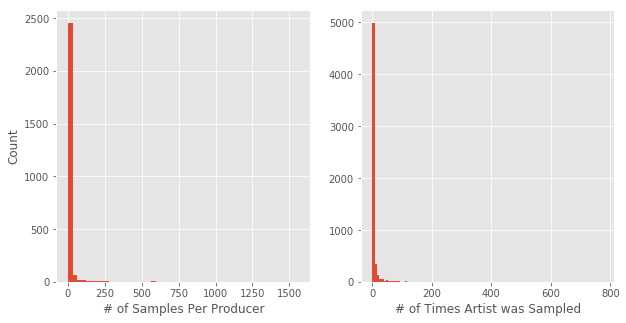

In [81]:
# Plot distributions of numbers of sampled, and max values.

producers = utility_to_artist.sum(axis =0)
sampled_artists = utility_to_artist.sum(axis =1)

prod_with_most_samples = utility_to_artist.sum(axis = 0).idxmax()
most_sampled_artist = utility_to_artist.sum(axis = 1).idxmax()
most_samples = utility_to_artist.sum(axis = 0).max()
times_sampled = utility_to_artist.sum(axis = 1).max()

print(
"{} is the producer with the most samples, with {} unique sampling instances.\n\
{} is the most sampled artist, sampled {} times.".format(
        prod_with_most_samples, most_samples, most_sampled_artist, times_sampled))

fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].set(xlabel = "# of Samples Per Producer", ylabel = "Count")
_ = ax[0].hist(producers, bins = 50)

# ax.annotate('local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )
ax[1].set(xlabel = "# of Times Artist was Sampled")
_ = ax[1].hist(sampled_artists, bins = 100)

In [82]:
# Top ten producers

utility_to_artist.sum(axis = 0).sort_values(ascending =False)\
.to_frame().rename(columns ={0:"Count"}).head(10)

,Count
new_song_producer,
Madlib,1562
9th Wonder,1122
The Alchemist,940
DJ Paul,930
DJ Premier,863
Juicy J,815
Kanye West,649
Knxwledge.,588
Prince Paul,575


In [83]:
# Top ten most sampled artists

utility_to_artist.sum(axis = 1).sort_values(ascending =False)\
.to_frame().rename(columns ={0:"Count"}).head(10)

#These results are shocking- Three 6 Mafia?

#I checked and they are right- three 6 gets sampled a lot.

,Count
sampled_artist,
James Brown,775
The Notorious B.I.G.,282
Public Enemy,252
Three 6 Mafia,251
Jay-Z,248
Kool & the Gang,213
Isaac Hayes,200
Michael Jackson,162
Doug E. Fresh,161


In [25]:
# How sparse is matrix?
for ut_mat, label in zip([utility_to_artist, utility_to_song], ["Artist Matrix", "Song Matrix"]):
    matrix_size = ut_mat.shape[0]*ut_mat.shape[1] # Number of possible interactions in the matrix
    nonzeros = sum(ut_mat.sum(axis=0))
    sparsity = 100*(1 - (nonzeros/matrix_size))
    print("{} has {} interactions out of {} possible, resulting in a {} % sparse matrix"
          .format(label, nonzeros, matrix_size, round(sparsity, 3)))

#We have a matrix that is 99.8% sparse. Kind of a problem. According to https://jessesw.com/Rec-System/ 
# maximum is 99.5%

#If we go by artist, we get down to 99.765%

Artist Matrix has 41861 interactions out of 20615686 possible, resulting in a 99.797 % sparse matrix
Song Matrix has 41861 interactions out of 51537626 possible, resulting in a 99.919 % sparse matrix


In [144]:
# May not use this cell.

from src.first_recommender_using_implict import get_model_and_user_items_from_utility_matrix
model, user_items_sparse = get_model_and_user_items_from_utility_matrix(utility_to_artist)

100%|██████████| 100.0/100 [00:06<00:00, 16.60it/s, loss=0.000813]


In [7]:
#What's up with Kanye?
print(utility_to_artist.loc["James Brown","Kanye West"])

#Actually, there is a 3 for Otis Redding- 
#is that because Kanye sampled him three times?

#An 11 for James Brown! Wow.

sum(utility_to_song.loc[:,"Kanye West"])
#Apparently he sampled 640 artists, also 640 songs.

11


649

In [8]:
utility_to_artist.head()

new_song_producer,"""Buttnaked"" Tim Dawg",$uicideboy$,10,12 Finger Dan,12 Million,138th,14Kt,1500 or Nothin',2 in Rhythm,21 Savage,...,Zavala,Zaytoven,Zen Zan,Zero 7,Zukhan Bey,d.r.u.g.s.,hAZEL,i.V.,nineteen85,will.i.am
sampled_artist,,,,,,,,,,,,,,,,,,,,,
"""Sweet"" Charles Sherrell",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'Lee' George Quinones,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
*NSYNC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1 Life 2 Live,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Make train set.
# First, we do in the most basic way: Set twenty percent of actual 
#interactions to non-interactions. Don't do it by row, just entire dataframe.

#transpose matrix, because he has users as columns (which certainly makes more sense.)
utility_to_artist_sparse = sparse.csr_matrix(utility_to_artist.T)

from src.make_train_set import make_train

train_set, test_set, user_rows_altered = make_train(utility_to_artist_sparse, 0.01)

In [11]:
#Settings from https://jessesw.com/Rec-System/
# He says these are best
#However the method is deprecated- I can use the recommendations thing instead but no alpha
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((train_set*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)

This method is deprecated. Please use the AlternatingLeastSquares class instead
100%|██████████| 50.0/50 [00:08<00:00,  6.09it/s]


In [15]:
from src.auc_testing import auc_score, calc_mean_auc

calc_mean_auc(train_set, user_rows_altered, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], test_set)

(0.752, 0.851)

In [19]:
# Record of scores
train_set = [0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005, .001, 0.0005]
alpha = 15

def test_different_train_test_split(split, alpha):
    
    '''
    This function splits data using make_train, 
    Trains a new model on the data and makes predictions using implicit library.
    Calculates mean_auc of the model as well as the mean_auc of popularity alone. 
    Input: A train_test split, alpha value.
    
    '''
    train_set, test_set, user_rows_altered = make_train(utility_to_artist_sparse, split)
    user_vecs, item_vecs = implicit.alternating_least_squares((train_set*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                         iterations = 50)
    return calc_mean_auc(train_set, user_rows_altered, [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], test_set)
    
scores = [test_different_train_test_split(split, alpha) for split in train_set]

100%|██████████| 50.0/50 [00:03<00:00, 12.80it/s]
100%|██████████| 50.0/50 [00:05<00:00,  9.27it/s]
100%|██████████| 50.0/50 [00:08<00:00,  9.58it/s]
100%|██████████| 50.0/50 [00:05<00:00, 10.28it/s]
100%|██████████| 50.0/50 [00:08<00:00,  5.74it/s]
100%|██████████| 50.0/50 [00:05<00:00, 11.13it/s]
100%|██████████| 50.0/50 [00:10<00:00,  4.95it/s]
100%|██████████| 50.0/50 [00:06<00:00,  8.03it/s]
100%|██████████| 50.0/50 [00:09<00:00,  5.43it/s]


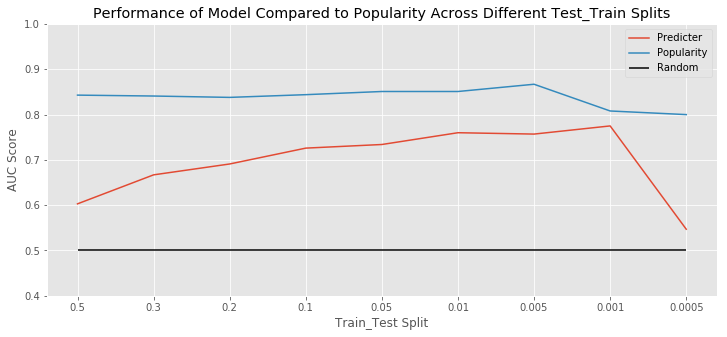

In [50]:
fig, ax = plt.subplots(figsize = (12, 5))
plt.xticks(np.arange(0, 9, 1), train_set)

#Plot Predicter versus Popularity alone. 

for num, label in zip(range(2), ["Predicter", "Popularity"]):
    ax.plot([i[num] for i in scores], label = label)
ax.hlines(0.5, 0, 8, label = "Random")
ax.set(xlabel = "Train_Test Split", 
       ylabel = "AUC Score", 
       title = "Performance of Model Compared to Popularity Across Different Test_Train Splits",
      ylim = (0.4, 1))
_ = ax.legend(loc = 'best')
    